In [1]:
import sys

sys.path.append("..")

In [2]:
import torch
import torchvision
from PIL import Image
from typing import List, Union, Tuple
import numpy as np
import matplotlib.pyplot as plt
import cv2
from segment.dino_script import run_dino, format_dino, get_dino_model, transform_image_dino
from segment.utils import get_device, image_handler
from segment.sam_results import format_boxes, format_scores
from segment.visualizer import display_image_with_masks_and_boxes

DEVICE = get_device()


class DinoDetector:
    def __init__(
        self,
        image: Union[str, Image.Image, List[Image.Image]],
        text_prompt: str,
        image_size: int = 1024,
        box_threshold: float = 0.3,
        text_threshold: float = 0.25,
        iou_threshold: float = 0.8,
    ):
        self.image_size = image_size
        self.device = DEVICE
        self.images = image_handler(image, self.image_size)
        self.dino_images = self.image_to_tensor()
        self.text_prompt = text_prompt
        self.model = self._get_dino_model()
        self.box_threshold = box_threshold
        self.text_threshold = text_threshold
        self.iou_threshold = iou_threshold
        self.boxes = None
        self.scores = None
        self.phrases = None

    def _get_dino_model(self):
        return get_dino_model()

    def image_to_tensor(self):
        with torch.no_grad():
            dino_images = torch.stack(
                [transform_image_dino(image) for image in self.images]
            )
        return dino_images.to(self.device)

    def run(self):
        self.boxes, self.scores, self.phrases = run_dino(
            self.model,
            self.dino_images,
            self.text_prompt,
            self.box_threshold,
            self.text_threshold,
        )

        self.boxes, self.scores, self.phrases = format_dino(
            self.boxes, self.scores, self.phrases, (self.image_size, self.image_size), self.iou_threshold
        )
    

    def asdict(self):
        boxes = format_boxes(self.boxes[0])
        scores = format_scores(self.scores[0])
        phrases = self.phrases[0]
        return [
            dict(box=box, score=score, label=phrases[idx])
            for idx, (box, score) in enumerate(zip(boxes, scores))
        ]

    def display_results(
        self,
        image_num=0,
        cols: int = 4,
    ):
        # Convert PIL Image to numpy array
        display_image_with_masks_and_boxes(self.images[image_num], self.asdict(), cols=cols)

In [3]:
from segment.utils import load_resize_image

In [4]:
# images 
im_path = "https://i.pinimg.com/originals/68/82/ce/6882cefe21f75234697e8508eb6a3232.jpg"
text_prompt = ["hair", "face", "neck", "arm", "hand", "back", "leg", "clothing", "phone", "hat", "foot"]

text_prompt = ".".join(text_prompt)

detector = DinoDetector(im_path, text_prompt)

detector.run()

detector.display_results()

final text_encoder_type: bert-base-uncased
Model loading result: _IncompatibleKeys(missing_keys=[], unexpected_keys=['label_enc.weight', 'bert.embeddings.position_ids'])


In [5]:
detector.run()

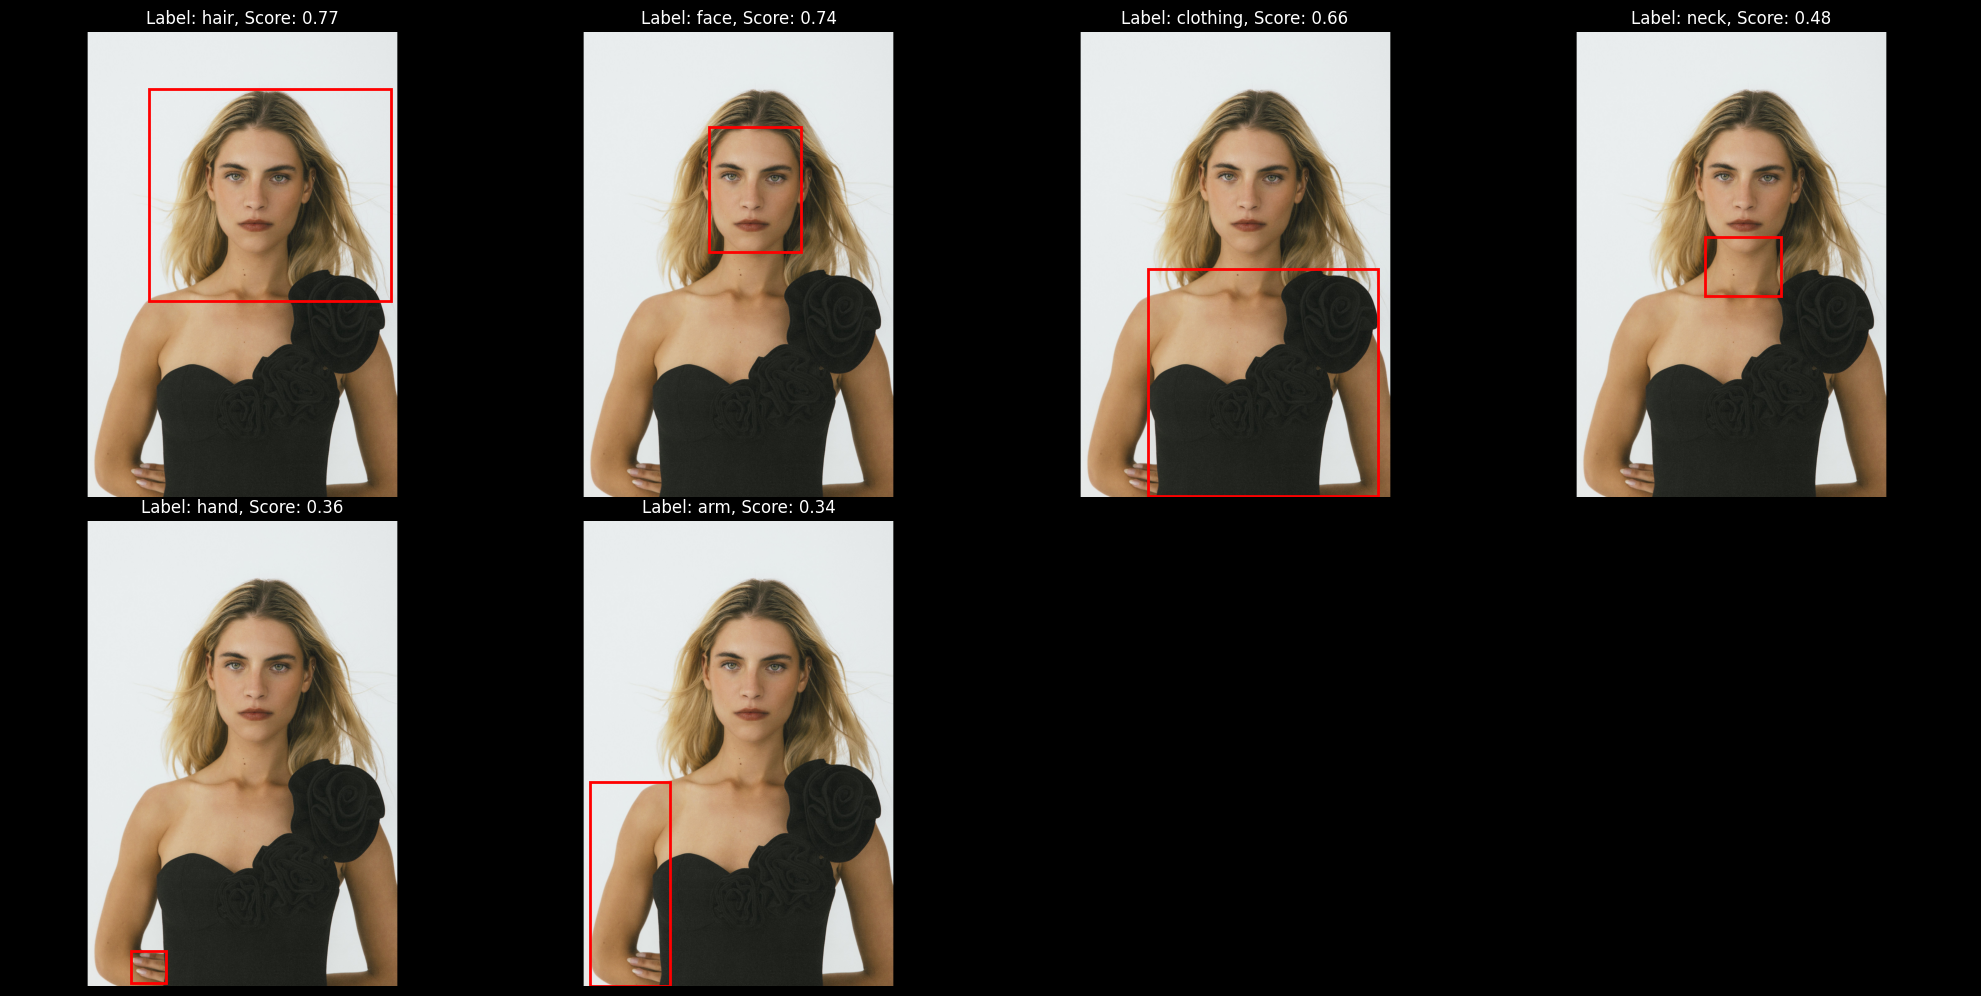

In [6]:
detector.display_results()